# 2-dimensional model without ancient samples

In [1]:
import msprime
import numpy as np
import allel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D     

## Sampling scheme

In [2]:
n = 10

Text(0.5,1,'Sampling scheme')

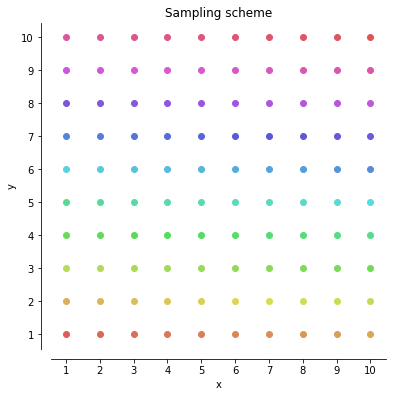

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
palette = sns.color_palette("hls", n*n)

x = list(range(1,n+1)) * n
x = np.asarray(x)
y = np.repeat(np.arange(1, n+1), n)
markers = np.repeat('o', n*n) # markers on the plot
markersizes = np.repeat(6, n*n)

for i in range(0,n*n):
    ax.plot(x[i], y[i], marker=markers[i], linestyle=' ', color=palette[i], markersize=markersizes[i])
#     plt.text(x[i]+0.1, y[i]+0.1, "pop"+str(i), color=palette[i])

ax.set_xticks(np.arange(1,n+1))
ax.set_xticklabels(np.arange(1,n+1))
ax.set_yticks(np.arange(1,n+1))
ax.set_yticklabels(np.arange(1,n+1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Sampling scheme')

## Simulation

In [7]:
def writePopulationConfigurations(nDemes, sampleSize):
    """
    nDemes = number of demes/populations to simulate
    sampleSize = number of individuals to sample in each deme/population (to simulate 1 diploid individual,
        sampleSize must be 2)
    """
    population_configurations = []
    for i in range(0, nDemes):
        population_configurations.append(msprime.PopulationConfiguration(sample_size=2))
    return(population_configurations)


def modernSamples(n, deme):
    """
    n = number of modern samples
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,n):
        samples.append(msprime.Sample(deme,0))
    return(samples)


def ancientSamples(nb, age, deme):
    """
    nb = number of ancient samples
    age = age of the samples, in generations
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,nb):
        samples.append(msprime.Sample(deme, age))
    return(samples)
    

In [8]:
def writeMigrationMatrix(n, rate):
    """
    Migrations in a 2-dimensional stepping-stone model with IBD.
        n = square root of the number of demes (e.g. if there are 100 demes, n=10)
        rate = migration rate between 2 demes
    """
    migration_matrix = np.zeros((n*n, n*n))
    # Bottom-left corner of the sampling scheme (deme 1, index 0, if n=10):
    migration_matrix[0, 1] = migration_matrix[1, 0] = migration_matrix[0, n] = migration_matrix[n, 0] = rate
    # Bottom-right corner of the sampling scheme (deme 10, index 9):
    migration_matrix[n-1, n-2] = migration_matrix[n-2, n-1] = migration_matrix[n-1, 2*n-1] = migration_matrix[2*n-1, n-1] = rate
    # Top-left corner of the sampling scheme (deme 91, index 90):
    migration_matrix[n*(n-1), n*(n-2)] = migration_matrix[n*(n-2), n*(n-1)] = migration_matrix[n*(n-1), n*(n-1)+1] = migration_matrix[n*(n-1)+1, n*(n-1)] = rate
    # Top-right corner of the sampling scheme (deme 100, index 99):
    migration_matrix[n*n-1, n*n-2] = migration_matrix[n*n-2, n*n-1] = migration_matrix[n*n-1, n*(n-1)-1] = migration_matrix[n*(n-1)-1, n*n-1] = rate
    
    # Demes on the bottom line of the sampling scheme:
    for i in range(1, n-1):
        migration_matrix[i, i+1] = migration_matrix[i+1, i] = migration_matrix[i, i-1] = migration_matrix[i-1, i] = rate
    # Demes on the top line of the sampling scheme:
    for i in range(n*(n-1)+1, n*n-2):
        migration_matrix[i, i+1] = migration_matrix[i+1, i] = migration_matrix[i, i-1] = migration_matrix[i-1, i] = rate
    # Demes on the left column of the sampling scheme:
    a = np.arange(1,n-1)
    a *= n
    for i in a:
        migration_matrix[i, i+n] = migration_matrix[i+n, i] = rate
        migration_matrix[i, i-n] = migration_matrix[i-n, i] = rate
    # Demes on the right column of the sampling scheme:
    a = np.arange(2, n)
    a *= n
    a -= 1
    for i in a:
        migration_matrix[i, i+n] = migration_matrix[i+n, i] = rate
        migration_matrix[i, i-n] = migration_matrix[i-n, i] = rate
    
    # Other demes:
    i = np.arange(1, n-1)
    j=[]
    for a in i:
        j.append(a*n + i)
    for k in j:
        for ind in k:
            migration_matrix[ind, ind-1] = migration_matrix[ind-1, ind] = rate
            migration_matrix[ind, ind+1] = migration_matrix[ind+1, ind] = rate
            migration_matrix[ind, ind+n] = migration_matrix[ind+n, ind] = rate
            migration_matrix[ind, ind-n] = migration_matrix[ind-n, ind] = rate

    
    return(migration_matrix)

In [9]:
Ne = 15000
M = 1
m = M / (4*Ne)

migration_matrix = writeMigrationMatrix(n, m)
population_configurations = writePopulationConfigurations(n*n, 2)

In [10]:
def ibd_2d(num_replicates, population_configurations, migration_matrix, nbDemes):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne = Ne,
                            population_configurations = population_configurations,
                            migration_matrix = migration_matrix,
                            length = 2, 
                            recombination_rate = 1e-8,
                            mutation_rate = 1e-8,
                            num_replicates = num_replicates
                                 )
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbDemes,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    
    return(haplotypes)

In [11]:
g = allel.model.GenotypeArray(ibd_2d(3000, population_configurations,
                                     migration_matrix, n*n))
g

<GenotypeArray shape=(3201, 100, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/1 0/1 0/0 0/0
0/1 1/1 1/1 1/1 1/1 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/1 0/0 0/0 0/1
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 1/1 ... 0/0 0/0 0/0 0/0 0/0
1/1 0/1 1/0 1/1 1/1 ... 1/1 0/1 1/1 1/1 1/1

In [12]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn, scaler = None)
coords.shape

demes = []
palette = sns.color_palette("hls", n*n)
deme_colors = {}
sample_list = []
for i in np.arange(n*n):
    name = "deme" + str(i+1)
    demes.append(name)
    deme_colors[name] = palette[i]

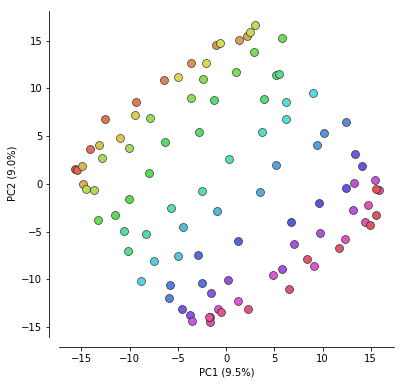

In [13]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for t in demes:
        x = coords[i:i+1, pc1]
        y = coords[i:i+1, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=t, markersize=8, mec='k', mew=.5, color=deme_colors[t])
        i += 1
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)

Text(0.5,1.02,'PC maps')

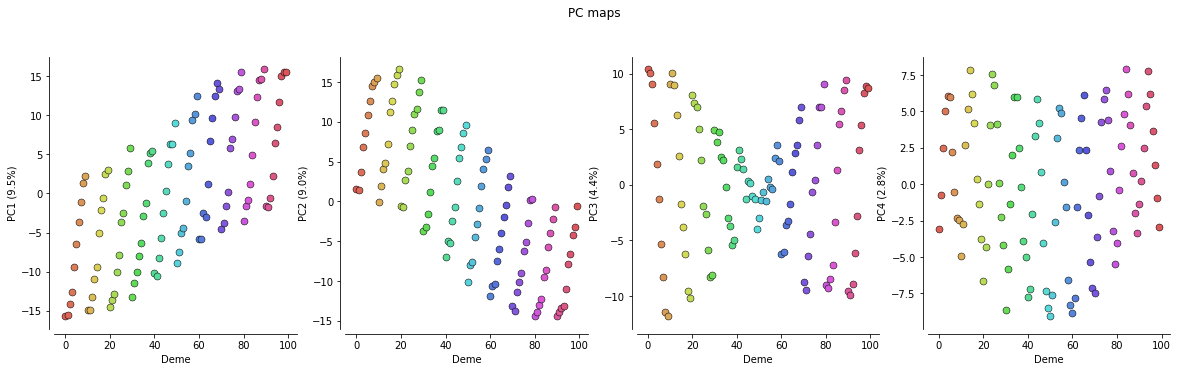

In [14]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the geographic positionof the corresponding sample location.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    for t in demes:
        y = coords[i:i+1, pc]
        ax.plot(i, y, marker='o', linestyle=' ', label=t, markersize=7, mec='k', mew=.5, color=deme_colors[t])
        i += 1
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Deme')
    
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(1,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(1,4,4)
plot_PC_maps(coords, model, 3, ax)
fig.suptitle('PC maps', y=1.02)

In [15]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(np.cov(gn, rowvar=False))

In 2D, PCA reproduces the geography of the samples.

The covariance matrix is a "block Toeplitz with Toeplitz blocks" matrix.

## Biased sampling

Consider a 3 x 3 sampling scheme, with samples taken as follows:

X X x<br>
x X o<br>
o X x

X = lots of samples<br>
x = a few samples<br>
o = no samples

In [16]:
def writePopulationConfigurations2(nDemes, sampleSize, lots_samples, sampleSize2, few_samples):
    """
    nDemes = number of demes/populations to simulate
    sampleSize = number of individuals to sample in each deme/population (to simulate 1 diploid individual,
        sampleSize must be 2)
    with_samples = list of indices of the demes in which sampleSize samples will be taken. The sample size will be zero in the other demes.
    """
    population_configurations = []
    for i in np.arange(nDemes):
        if i in lots_samples:
            population_configurations.append(msprime.PopulationConfiguration(sample_size=sampleSize))
        elif i in few_samples:
            population_configurations.append(msprime.PopulationConfiguration(sample_size=sampleSize2))
        else:
            population_configurations.append(msprime.PopulationConfiguration(sample_size=0))
    return(population_configurations)

In [17]:
Ne = 15000
M = 1
m = M / (4*Ne)
n = 3

migration_matrix = writeMigrationMatrix(n, m)

## Unequal sampling
lots_samples = [1, 4, 6, 7]
sampleSize = 10 #nb of haploid samples
few_samples = [2, 3, 8]
sampleSize2 = 2
all_samples = []
for i in np.arange(int(sampleSize/2)):
    all_samples += lots_samples
for i in np.arange(int(sampleSize2/2)):
    all_samples += few_samples
all_samples = sorted(all_samples)

population_configurations = writePopulationConfigurations2(n*n, sampleSize, lots_samples, sampleSize2, few_samples)

In [18]:
def unequal_sampling(num_replicates, population_configurations, migration_matrix, nbDemesWithSamples1, nbSamples1,
                               nbDemesWithSamples2, nbSamples2):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne = Ne,
                            population_configurations = population_configurations,
                            migration_matrix = migration_matrix,
                            length = 40, 
                            recombination_rate = 1e-8,
                            mutation_rate = 1e-8,
                            num_replicates = num_replicates
                                 )
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbDemesWithSamples1 * nbSamples1 + nbDemesWithSamples2 * nbSamples2,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    
    return(haplotypes)

In [19]:
g2 = allel.model.GenotypeArray(unequal_sampling(6000, population_configurations,
                                                migration_matrix, len(lots_samples), int(sampleSize/2),
                                                len(few_samples), int(sampleSize2/2)))
g2

<GenotypeArray shape=(7189, 23, 2) dtype=int8>
1/0 1/1 1/1 0/1 0/1 ... 1/1 1/0 1/1 1/1 0/1
1/0 0/1 1/1 0/1 0/1 ... 0/0 1/0 1/1 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 1/1
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 1/1 1/0 0/0 0/0

In [20]:
gn2 = g2.to_n_alt()[:]

# PCA
coords2, model2 = allel.stats.pca(gn2)
coords2.shape

demes = []
palette = sns.color_palette("hls", n*n)
deme_colors = {}
sample_list = []
for i in np.arange(n*n):
    name = "deme" + str(i+1)
    demes.append(name)
    deme_colors[name] = palette[i]
    for j in np.arange(n*n):
        sample_list.append(name)

Text(0.5,1,'Sampling scheme')

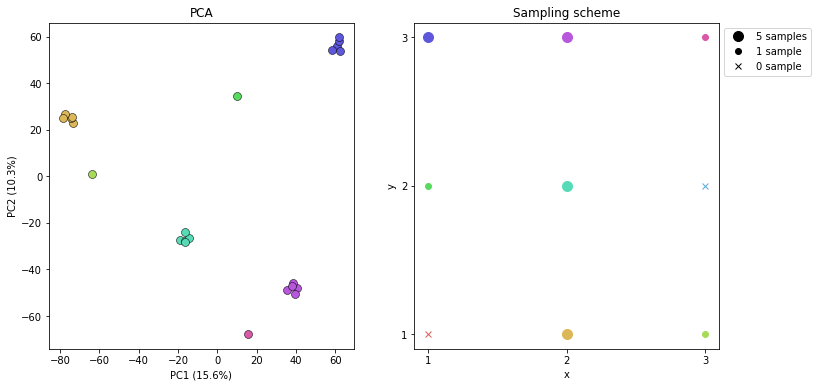

In [21]:
def plot_pca_coords2(coords, model, pc1, pc2, ax):
    for i in np.arange(g2.shape[1]):
        x = coords[i:i+1, pc1]
        y = coords[i:i+1, pc2]
        j = all_samples[i]
        ax.plot(x, y, marker='o', linestyle=' ', markersize=8, mec='k', mew=.5, color=palette[j])
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

fig = plt.figure(figsize=(12, 6))
sns.despine(ax=ax, offset=10)
ax = fig.add_subplot(1,2,1)
# PCA
plot_pca_coords2(coords2, model2, 0, 1, ax)
ax.set_title("PCA")

ax = fig.add_subplot(1,2,2)
# Sampling scheme
x = list(range(1,n+1)) * 3
x = np.asarray(x)
y = np.repeat(np.arange(1, n+1), 3)
markers = ['o'] * (n*n)
markersizes = [10] * (n*n)
no_samples = list(set(np.arange(n*n)) ^ set(lots_samples + few_samples))
for i in few_samples:
    markersizes[i] = 6
for i in no_samples:
    markers[i] = 'x'
    markersizes[i] = 6
for i in range(0,n*n):
    ax.plot(x[i], y[i], marker=markers[i], linestyle=' ', color=palette[i], markersize=markersizes[i])
ax.set_xticks(np.arange(1,n+1))
ax.set_xticklabels(np.arange(1,n+1))
ax.set_yticks(np.arange(1,n+1))
ax.set_yticklabels(np.arange(1,n+1))
ax.set_xlabel('x')
ax.set_ylabel('y')
lots = Line2D([], [], color='black', marker='o',
                          markersize=10, label='5 samples', linestyle=' ')
few = Line2D([], [], color='black', marker='o',
                          markersize=6, label='1 sample', linestyle=' ')
none = Line2D([], [], color='black', marker='x',
                          markersize=6, label='0 sample', linestyle=' ')
ax.legend(handles=[lots, few, none], bbox_to_anchor=(1,1), loc='upper left')
ax.set_title('Sampling scheme')

Unequal sampling distorts PCA ([McVean, 2009](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000686)).